# Mount Drive (Optional)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# Clone the main repository

In [22]:
!git clone https://github.com/arielz001/Hands-On-SDM.git

fatal: destination path 'Hands-On-SuperNormal' already exists and is not an empty directory.


### Download pretrained model

In [1]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1VX-Kg8yrFLgTGVLdVFuPYuE9lLecLmOb"

Downloading...
From (original): https://drive.google.com/uc?id=1VX-Kg8yrFLgTGVLdVFuPYuE9lLecLmOb
From (redirected): https://drive.google.com/uc?id=1VX-Kg8yrFLgTGVLdVFuPYuE9lLecLmOb&confirm=t&uuid=1d627252-3ab5-4b97-a16e-1ab4352dc6bc
To: /home/ariel/ComputerVision/Hands-On-SDM/checkpoint.zip
100%|████████████████████████████████████████| 467M/467M [00:05<00:00, 80.2MB/s]


In [2]:
!unzip checkpoint.zip
!mv ./checkpoint ./SDM-UniPS/

Archive:  checkpoint.zip
   creating: checkpoint/brdf/
  inflating: checkpoint/brdf/brdf.pytmodel  
   creating: checkpoint/normal/
  inflating: checkpoint/normal/nml.pytmodel  


# Install Libraries

# Now, we will take images with the phone and differents lights

In [4]:
obj_name = input("Add object's name: ")

# If you are using COLAB you should run this code 

In [1]:
from IPython.display import display, Javascript
# from google.colab import output
import base64
import PIL.Image
import io
import time
import os

js = """
async function takePhoto() {
  const div = document.createElement('div');
  const capture = document.createElement('button');
  capture.textContent = 'Capture';
  div.appendChild(capture);
  document.body.appendChild(div);

  const video = document.createElement('video');
  video.style.display = 'block';
  const stream = await navigator.mediaDevices.getUserMedia({video: true});
  video.srcObject = stream;
  video.play();
  div.appendChild(video);

  await new Promise((resolve) => capture.onclick = resolve);
  const canvas = document.createElement('canvas');
  canvas.width = video.videoWidth;
  canvas.height = video.videoHeight;
  canvas.getContext('2d').drawImage(video, 0, 0);
  stream.getTracks().forEach(track => track.stop());
  div.remove();
  return canvas.toDataURL('image/jpeg', 0.9);
}
"""
def take_photo():
    vista = input("Add view's number: ")
    dirdata = f"Hands-On-SuperNormal/SDM-UniPS/data"
    !mkdir {dirdata}
    dir = f"Hands-On-SuperNormal/SDM-UniPS/data/{obj_name}"
    !mkdir {dir}
    dir2 = f"{dir}/{vista}.data"
    !mkdir {dir2}
    for luz in range(5):
      display(Javascript(js))
      data = output.eval_js('takePhoto()')
      img_data = base64.b64decode(data.split(",")[1])
      image = PIL.Image.open(io.BytesIO(img_data))
    
      filename = f"{dir2}/L ({luz}).png"
      luz += 1
      image.save(filename)
      print(f"Imagen guardada como: {filename}")
    
    # Acumular para promedio
    frame_float = frame.astype(np.float32)
    if accum_image is None:
        accum_image = frame_float
    else:
        accum_image += frame_float
    
    avg_image = (accum_image / 5).astype(np.uint8)
    avg_filename = os.path.join(vista_dir, f"{vista}.png")
    cv2.imwrite(avg_filename, avg_image)
    print(f"Mean image saved as: {avg_filename}")

    
take_photo()


La sintaxis del comando no es correcta.


NameError: name 'obj_name' is not defined

### IF you are using your local machine, you can take images 

In [2]:
obj_name = input("Add object's name: ")

In [26]:
import cv2
import os
import numpy as np

vista = input("Add view's number: ")

base_dir = "SDM-UniPS/data"
os.makedirs(base_dir, exist_ok=True)
obj_dir = os.path.join(base_dir, obj_name)
os.makedirs(obj_dir, exist_ok=True)
vista_dir = os.path.join(obj_dir, f"{vista}.data")
os.makedirs(vista_dir, exist_ok=True)

avg_images_dir = f"{obj_dir}/average_lights"
os.makedirs(avg_images_dir, exist_ok=True)
# url = "http://10.66.231.92:8080"
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("Cam is not able to open")


for luz in range(10):
    while True:
        ret, frame = cap.read()
        if not ret:
            continue

        cv2.imshow("Press 'c' to capture", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('c'):
            filename = os.path.join(vista_dir, f"L ({luz}).png")
            cv2.imwrite(filename, frame)
            print(f"Saved Image as: {filename}")
            break

cap.release()
cv2.destroyAllWindows()



Saved Image as: SDM-UniPS/data/stumble/3.data/L (0).png
Saved Image as: SDM-UniPS/data/stumble/3.data/L (1).png
Saved Image as: SDM-UniPS/data/stumble/3.data/L (2).png
Saved Image as: SDM-UniPS/data/stumble/3.data/L (3).png
Saved Image as: SDM-UniPS/data/stumble/3.data/L (4).png
Saved Image as: SDM-UniPS/data/stumble/3.data/L (5).png
Saved Image as: SDM-UniPS/data/stumble/3.data/L (6).png
Saved Image as: SDM-UniPS/data/stumble/3.data/L (7).png
Saved Image as: SDM-UniPS/data/stumble/3.data/L (8).png
Saved Image as: SDM-UniPS/data/stumble/3.data/L (9).png


# Generate Masks

In [7]:
# !pip install transformers segmentation_refinement
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib
!pip install transformers

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-byomxn83
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-byomxn83
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


#### Now, We are going to generate masks to estimate normals

In [8]:
!wget -O sam_vit_b_01ec64.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2025-12-07 17:02:15--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 2600:9000:261c:9600:13:6e38:acc0:93a1, 2600:9000:261c:8c00:13:6e38:acc0:93a1, 2600:9000:261c:c600:13:6e38:acc0:93a1, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|2600:9000:261c:9600:13:6e38:acc0:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M  75.9MB/s    in 4.5s    

2025-12-07 17:02:21 (79.0 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [23]:
# obj_name = 'corch'

Device set to use cuda:0


Files inside folder:
'L (0).png'  'L (2).png'  'L (4).png'  'L (6).png'  'L (8).png'
'L (1).png'  'L (3).png'  'L (5).png'  'L (7).png'  'L (9).png'
[INFO] depth map: (480, 640)
[INFO] Generating SAM masks on depth map...
[INFO] Total masks: 11


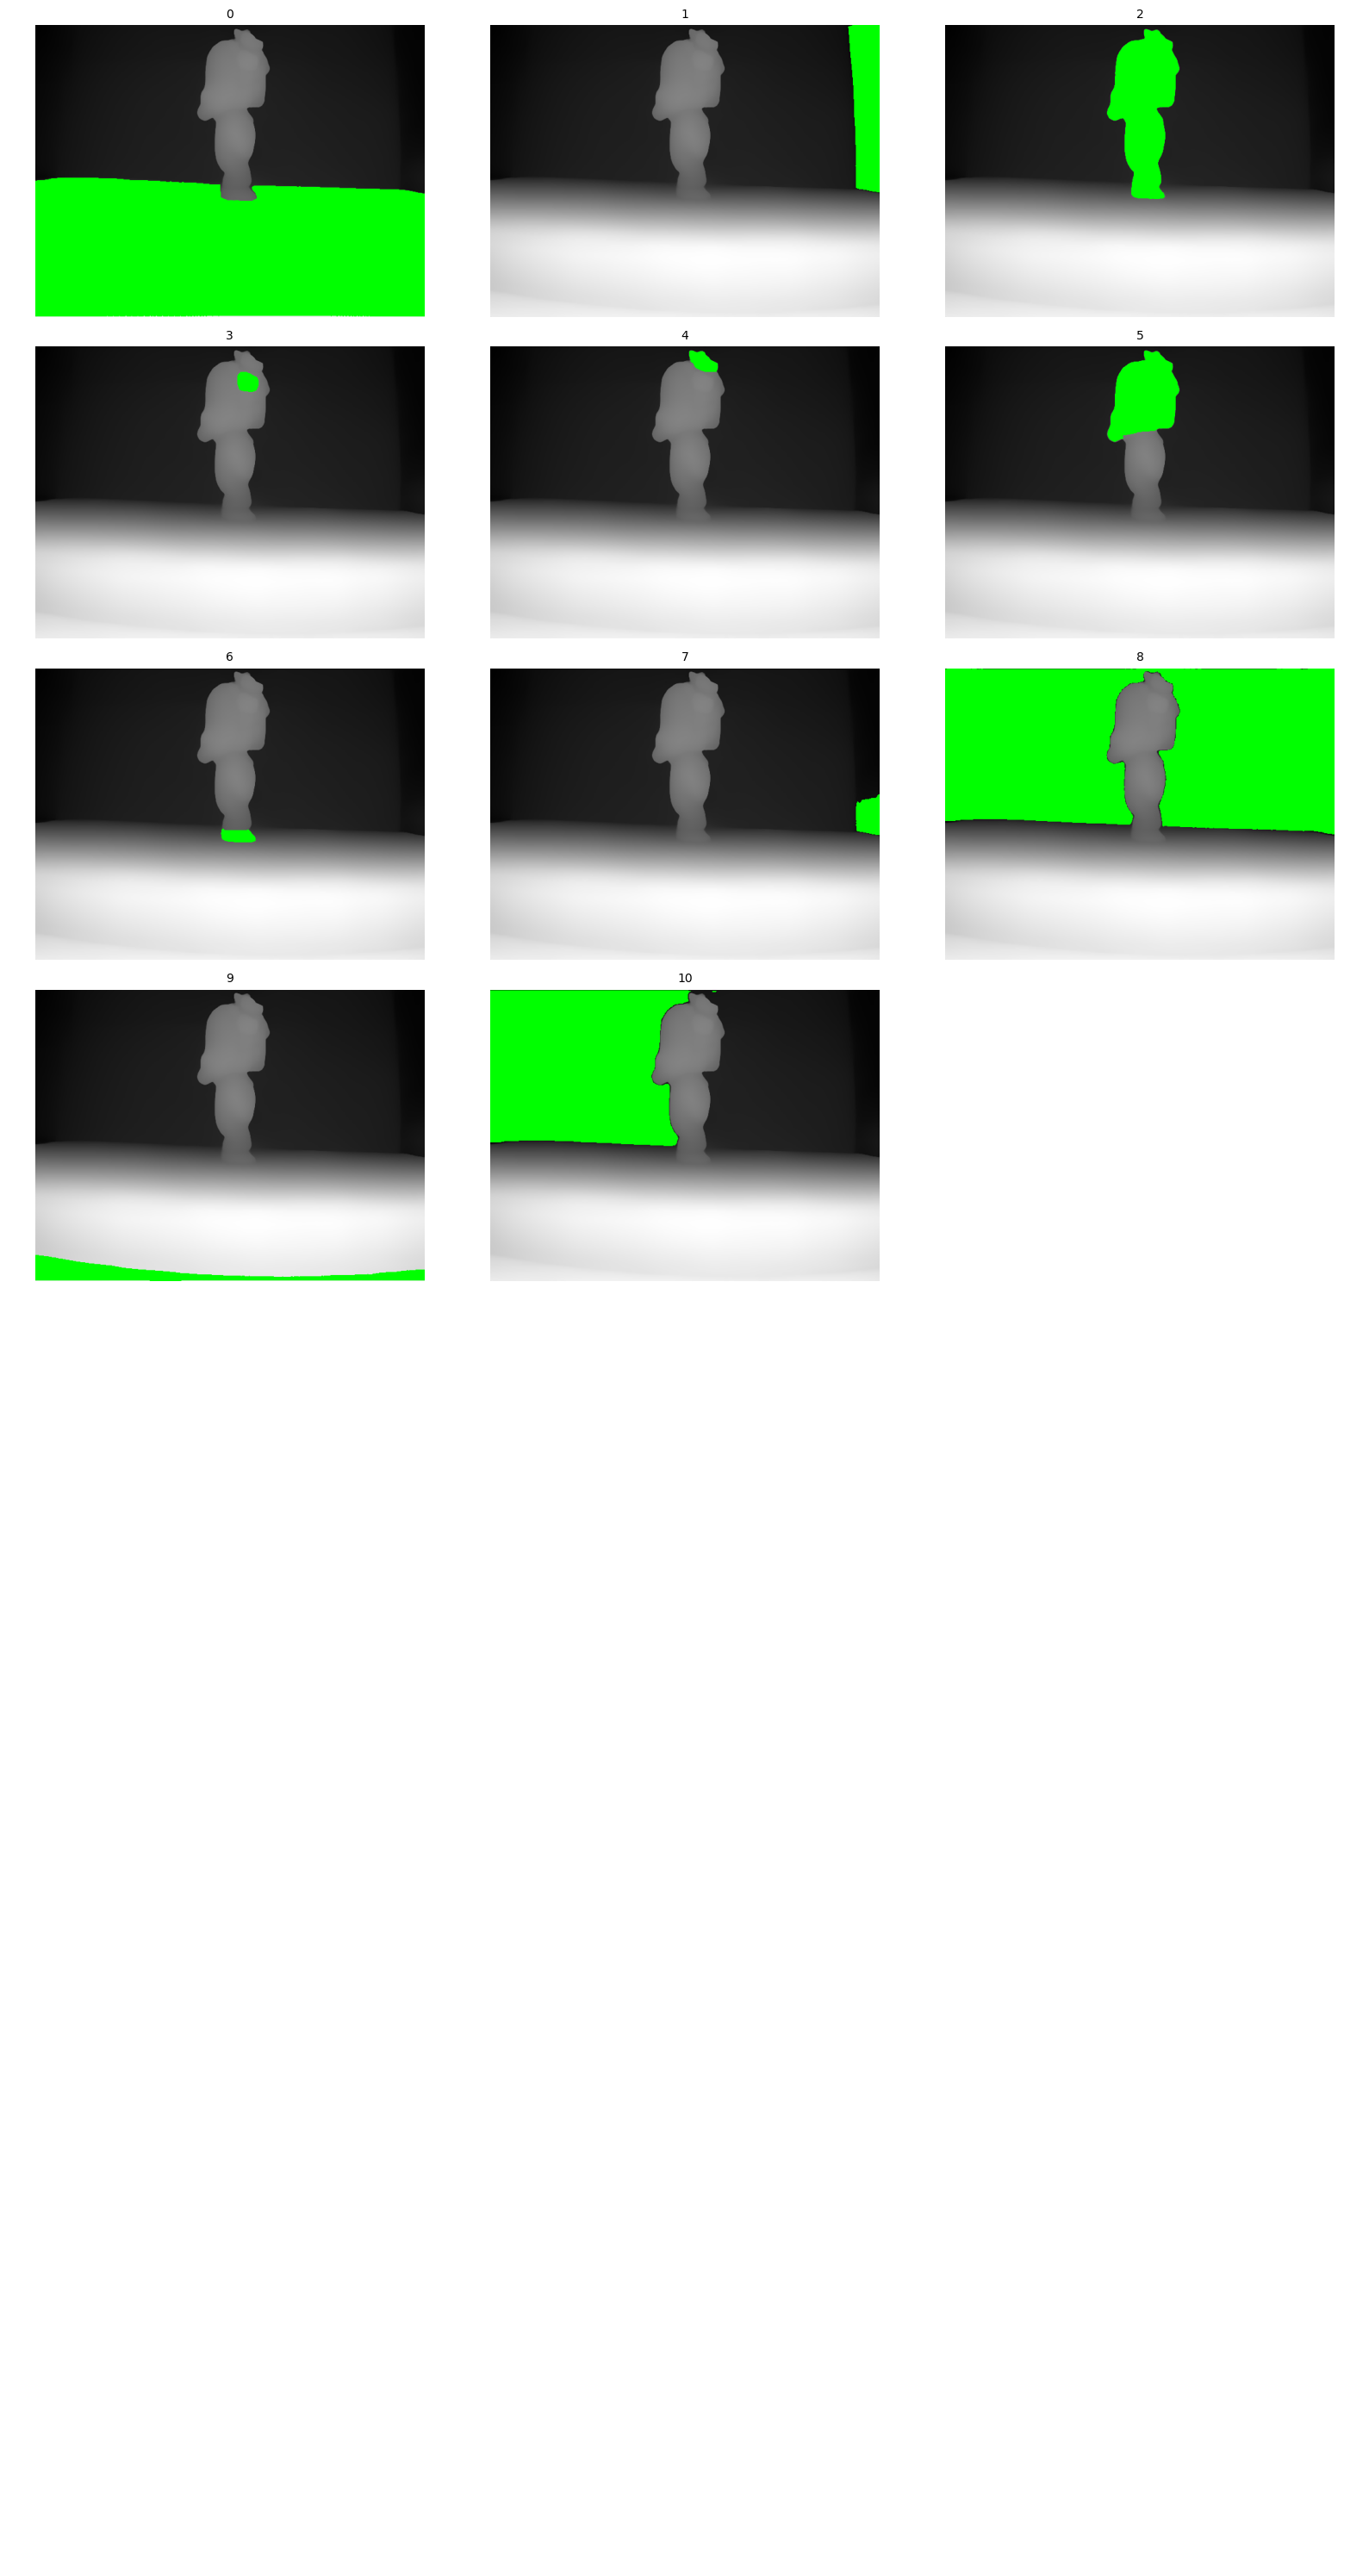

[INFO] Saved mask 2 → SDM-UniPS/data/stumble/3.data/mask.png


In [29]:
### import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torch
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
sam.to("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from PIL import Image
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import cv2
# --------------------------------------------------
# DEPTH ANYTHING (transfomers pipeline)
# --------------------------------------------------
pipe = pipeline(
    task="depth-estimation",
    model="depth-anything/Depth-Anything-V2-Small-hf"
)

def get_depth(image_pil):
    depth_pil = pipe(image_pil)["depth"]  # PIL Image
    depth_np = np.array(depth_pil).astype(np.float32)
    print(f"[INFO] depth map:", depth_np.shape)
    return depth_np


# --------------------------------------------------
# INPUT
# --------------------------------------------------
vista = input("Add view's number to mask: ")

img_path = f"SDM-UniPS/data/{obj_name}/{vista}.data/L (6).png"
print("Files inside folder:")
!ls "SDM-UniPS/data/{obj_name}/{vista}.data/"
# ========================================================================
# Load image
img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

# --------------------------------------------------
# DEPTH
# --------------------------------------------------
depth_map = get_depth(Image.fromarray(img_rgb))

# Normalizar depth → 0–255 (SAM requiere imagen visual)
depth_norm = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
depth_uint8 = (depth_norm * 255).astype(np.uint8)
depth_rgb = cv2.cvtColor(depth_uint8, cv2.COLOR_GRAY2RGB)

# --------------------------------------------------
# LOAD SAM
# --------------------------------------------------
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side=30,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.92,
    min_mask_region_area=10
)

# --------------------------------------------------
# RUN SAM ON DEPTH MAP
# --------------------------------------------------
print("[INFO] Generating SAM masks on depth map...")
masks = mask_generator.generate(depth_rgb)
print(f"[INFO] Total masks: {len(masks)}")

# --------------------------------------------------
# SHOW 80 MASKS
# --------------------------------------------------
mask_dict = {}
max_masks = min(len(masks), 24)
n_cols, n_rows = 3,8

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 30))
axes = axes.flatten()

for idx in range(max_masks):
    m = masks[idx]
    mask_uint8 = (m['segmentation'].astype(np.uint8) * 255)

    display_img = depth_rgb.copy()
    display_img[mask_uint8 > 0] = [0, 255, 0]  # Verde

    axes[idx].imshow(display_img)
    axes[idx].set_title(f"{idx}", fontsize=10)
    axes[idx].axis('off')

    mask_dict[idx] = mask_uint8

for ax in axes[max_masks:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# --------------------------------------------------
# SELECT ONE MASK AND SAVE
# --------------------------------------------------
selected_idx = int(input(f"Select SAM mask index (0-{max_masks-1}): "))
selected_mask = mask_dict[selected_idx]

mask_path = f"SDM-UniPS/data/{obj_name}/{vista}.data/mask.png"
cv2.imwrite(mask_path, selected_mask)
print(f"[INFO] Saved mask {selected_idx} → {mask_path}")


### Get Normals from SDM Uni-PS

In [30]:
!python SDM-UniPS/main.py \
    --session_name SDM-UniPS/results/stumble  \
    --test_dir SDM-UniPS/data/stumble \
    --checkpoint SDM-UniPS/checkpoint/ \
    --target normal_and_brdf


Starting a session: SDM-UniPS/results/stumble
target: normal_and_brdf

Loading pretrained model... SDM-UniPS/checkpoint//normal/nml.pytmodel 
Loading pretrained model... SDM-UniPS/checkpoint//brdf/brdf.pytmodel 

canonical resolution: 256 x 256  
pixel samples: 10000

Exploring SDM-UniPS/data/stumble
Found 4 objects!

Testing on 0.data
image index: [2 7 4 5 9 0 1 8 3 6]
original crop size: 262 x 261
resized crop size: 512 x 512
number of images: 10 / 10 (max)

Recovering normal_and_brdf map(s) 1 / 1
Testing on 1.data
image index: [5 1 8 2 9 6 3 4 0 7]
original crop size: 480 x 640
resized crop size: 512 x 512
number of images: 10 / 10 (max)

Recovering normal_and_brdf map(s) 1 / 1
Testing on 2.data
image index: [1 6 7 3 8 4 5 0 9 2]
original crop size: 280 x 280
resized crop size: 512 x 512
number of images: 10 / 10 (max)

Recovering normal_and_brdf map(s) 1 / 1
Testing on 3.data
image index: [5 0 1 3 4 2 6 7 8 9]
original crop size: 480 x 640
resized crop size: 512 x 512
number of im

In [25]:
!python SDM-UniPS/relighting.py --datadir ./SDM-UniPS/results/stumble/results/0.data

Render images |                              | 100.0% 


In [32]:
import torch
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
def comp_depth_4edge_sparse(mask, normal):
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()
    if isinstance(normal, torch.Tensor):
        normal = normal.cpu().numpy()

    h, w = mask.shape
    n_pixels = h * w

    mask = (mask > 0.5).astype(np.float32)
    indices = lambda i, j: i * w + j

    nx = normal[:, :, 0].flatten()
    ny = normal[:, :, 1].flatten()
    nz = normal[:, :, 2].flatten() + 1e-8

    p = -nx / nz
    q = -ny / nz

    rows = []
    cols = []
    data = []
    b = []

    for i in range(h):
        for j in range(w):
            if mask[i, j] == 0:
                continue
            idx = indices(i, j)

            if j < w - 1 and mask[i, j + 1] == 1:
                idx_r = idx + 1
                rows += [len(b), len(b)]
                cols += [idx, idx_r]
                data += [-1, 1]
                b.append(p[idx])

            if i < h - 1 and mask[i + 1, j] == 1:
                idx_d = idx + w
                rows += [len(b), len(b)]
                cols += [idx, idx_d]
                data += [-1, 1]
                b.append(q[idx])

            if j > 0 and mask[i, j - 1] == 1:
                idx_l = idx - 1
                rows += [len(b), len(b)]
                cols += [idx, idx_l]
                data += [1, -1]
                b.append(p[idx])

            if i > 0 and mask[i - 1, j] == 1:
                idx_u = idx - w
                rows += [len(b), len(b)]
                cols += [idx, idx_u]
                data += [1, -1]
                b.append(q[idx])

    A = scipy.sparse.coo_matrix((data, (rows, cols)), shape=(len(b), n_pixels))
    b = np.array(b)

    AtA = A.T @ A
    Atb = A.T @ b
    # x = scipy.sparse.linalg.spsolve(AtA, Atb)
    x = scipy.sparse.linalg.lsmr(A, b)[0]


    depth = x.reshape(h, w)
    depth -= depth.min()
    depth[mask == 0] = 0.0

    return depth

In [33]:
from utils import obj_functions as ob
def depth_process(normal, mask=None, albedo=None, path=None):
    # normal_map = ((normal / 255.0) * 2) - 1.0
    if mask is None:
        mask = np.ones(normal[:, :, 0].shape, dtype=np.uint8) * 255
    normal[mask == 0] = [0.0, 0.0, 0.0]
    print(f"mask.shape in depth_process: {mask.shape}")
    normal[:, :, 1] = normal.copy()[:, :, 1] * -1
    depth = comp_depth_4edge_sparse(mask, normal)
    if depth.ndim == 2:
        depth = depth[:, :, None]
    ver, tri = ob.Depth2VerTri(depth, mask)
    temp_albedo = albedo.astype(np.uint8)
    ob.save_as_ply(f"{path}/normals_recover.ply", depth, normal, temp_albedo, mask, tri)
    return depth




In [ ]:
def normals2depth(path_results, path_mask):
    for vista in os.listdir(path_results):
        normal = plt.imread(os.path.join(path_results, vista, 'normal.png')).astype(np.float32)


        normal = normal[:, :, :3]  # if this have alpha
        normal = normal * 2.0 - 1.0  # normalize

        mask = cv2.imread(os.path.join(path_mask, vista, 'mask.png'), cv2.IMREAD_GRAYSCALE)
        color_img = cv2.imread(os.path.join(path_mask, vista, 'L (1).png'), cv2.IMREAD_UNCHANGED)

        normals = normal.copy()
        normals[mask == 0] = 0

        depth = depth_process(normals, mask, albedo=color_img, path=os.path.join(path_results, vista))

        plt.imshow(depth, cmap='gray')
        plt.show()


normals2depth('SDM-UniPS/results/stumble/results', path_mask='SDM-UniPS/data/stumble')

mask.shape in depth_process: (480, 640)


## Download

In [91]:
import shutil
from google.colab import files

root_folder = "SDM-UniPS/data/duck"
zip_name = "duck_all_data"
shutil.make_archive(base_name=zip_name, format='zip', root_dir=root_folder)
files.download(f"{zip_name}.zip")

root_folder_results = "duck/results"
zip_name_results = "normals_duck_all_data"
shutil.make_archive(base_name=zip_name_results, format='zip', root_dir=root_folder_results)
files.download(f"{zip_name_results}.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>